###### -----------------START--------------------------------------------

In [1]:
import json

In [2]:
import os

In [3]:
from tqdm import tqdm

In [4]:
train_file_path = '/home/aritra/cric/train_questions.json'
val_file_path = '/home/aritra/cric/val_questions.json'

In [5]:
# Training Set

with open(train_file_path, "r") as file:
     train_json = json.load(file)

In [6]:
# Validation Set

with open(val_file_path, "r") as file:
     val_json = json.load(file)

In [7]:
len(train_json)

365235

In [8]:
len(val_json)

43112

In [9]:
# train_json

In [10]:
# val_json

##### Processing of Training Set

In [11]:
questionList = []
answerList = []
imgList = []

In [12]:
train_json[2]['image_id']

1005

#### iter 1: from 0 , 149000 -> error1.txt -> 159
#### iter 2: from 150000 , 240000 -> error2.txt -> 34
#### iter 3: from 240000 , 365235 ->error3.txt -> 121

In [13]:
# verifying
indexToExclude = []

with open('error1.txt', 'r') as file:
    for line in file:
        number = int(line.strip())
        indexToExclude.append(number)
        
with open('error2.txt', 'r') as file:
    for line in file:
        number = int(line.strip())
        indexToExclude.append(number)
        
with open('error3.txt', 'r') as file:
    for line in file:
        number = int(line.strip())
        indexToExclude.append(number)

In [14]:
len(indexToExclude)

314

In [15]:
for i in tqdm(range(len(train_json))):
    
    if i in indexToExclude:
        continue
        
    pointer = train_json[i]
    
    questionList.append(pointer['question'])
    answerList.append(pointer['answer'])
    imgList.append(pointer['image_id'])

100%|███████████████████████████████████| 365235/365235 [00:01<00:00, 333509.01it/s]


In [16]:
len(questionList), len(answerList), len(imgList)

(364921, 364921, 364921)

In [17]:
len(list(set(answerList)))

1442

In [18]:
# creating word to number mapping

mapping = {}
counter = 0

uniqueAnsList = list(set(answerList))

for word in uniqueAnsList:
    
    if word not in mapping:
        
        mapping[word] = counter
        counter += 1

In [19]:
max(mapping.values())

1441

In [20]:
# creating number to word mapping

reverse_mapping = dict([(value, key) for key, value in mapping.items()])

####    Processing of Training Set

In [21]:
# generating multiple possible answers
# palabels means possible answers

import random

palabels = []
temp = []

for i in tqdm(range(len(answerList))):
    
    temp.append(answerList[i])
    temp.append(uniqueAnsList[random.randint(0,1441)])
    temp.append(uniqueAnsList[random.randint(0,1441)])
    temp.append(uniqueAnsList[random.randint(0,1441)])
    
    random.shuffle(temp)
    palabels.append(temp)
    
    temp = []
    

100%|███████████████████████████████████| 364921/364921 [00:01<00:00, 283306.27it/s]


In [22]:
palabels[0:5]

[['beach chair', 'blueberry', 'bush', 'no'],
 ['tennis shoe', 'meadow', 'no', 'orange'],
 ['cabbage', 'toiletries', 'no', 'yellow'],
 ['wok', 'swan', 'small', 'can'],
 ['student', 'computer desk', 'picture', 'street']]

In [23]:
# creating scores of occurence list

scores = []
stemp = []

for i in tqdm(range(len(answerList))):
    correctAnswer = answerList[i]
    
    for j in range(4):
        
        if palabels[i][j] == correctAnswer:
            
            stemp.append(1.0)
        
        else:
            
            stemp.append(0.33333333333)
    
    scores.append(stemp)
    stemp = []
    

100%|███████████████████████████████████| 364921/364921 [00:02<00:00, 126489.03it/s]


In [24]:
scores[0:5]

[[0.33333333333, 0.33333333333, 0.33333333333, 1.0],
 [0.33333333333, 0.33333333333, 1.0, 0.33333333333],
 [0.33333333333, 0.33333333333, 1.0, 0.33333333333],
 [0.33333333333, 0.33333333333, 1.0, 0.33333333333],
 [0.33333333333, 0.33333333333, 1.0, 0.33333333333]]

In [25]:
# converting the palabels to numbers through mapping

for i in range(len(palabels)):
    
    for j in range(4):
        
        palabels[i][j] = mapping[ palabels[i][j] ]


In [26]:
palabels[0:5]

[[231, 348, 1315, 423],
 [450, 1404, 423, 532],
 [504, 1116, 423, 869],
 [460, 472, 1252, 1348],
 [914, 144, 1373, 1295]]

In [27]:
imgPathList = []
filepath = '/home/aritra/cric/images/img/'

for i in tqdm(range(len(imgList))):
    
    imgName = str(imgList[i]) + '.jpg'
    concatedPath = os.path.join(filepath,imgName)
    
    imgPathList.append(concatedPath)

100%|███████████████████████████████████| 364921/364921 [00:00<00:00, 779002.13it/s]


In [28]:
from datasets import load_dataset
from datasets import Dataset
import datasets
from PIL import Image
import torch

In [29]:
imgPathList[0:5]

['/home/aritra/cric/images/img/1000.jpg',
 '/home/aritra/cric/images/img/1005.jpg',
 '/home/aritra/cric/images/img/1005.jpg',
 '/home/aritra/cric/images/img/1005.jpg',
 '/home/aritra/cric/images/img/1008.jpg']

In [30]:
len(imgPathList)

364921

In [31]:
listToDictionary = {'questions':questionList, 'answers':palabels, 'scores':scores, 'images':imgPathList}
modified_train_set = Dataset.from_dict(listToDictionary)

In [32]:
# mapping each filepath to images in the directory

modified_train_set = modified_train_set.cast_column("images", datasets.Image())

In [33]:
modified_train_set

Dataset({
    features: ['questions', 'answers', 'scores', 'images'],
    num_rows: 364921
})

In [34]:
import numpy as np
test_img = modified_train_set[400]['images'].convert('RGB')
test_img.thumbnail((300,300))
a = np.asarray(test_img)

### Processing of Validation Set

In [145]:
questionList_val = []
answerList_val = []
imgList_val = []

In [146]:
val_json[6904]['answer']

'white'

In [147]:
# collecting the index containing errorneous images

indexToExcludeVal = []
with open('error_validation.txt', 'r') as file:
    for line in file:
        number = int(line.strip())
        indexToExcludeVal.append(number)
            
with open('error_validation2.txt', 'r') as file:
    for line in file:
        number = int(line.strip())
        indexToExcludeVal.append(number)

In [148]:
# excluding the index containing errorneous images

for i in tqdm(range(len(val_json))):
    
    if (i in indexToExcludeVal):
        continue
        
    pointer = val_json[i]
    
    questionList_val.append(pointer['question'])
    answerList_val.append(pointer['answer'])
    imgList_val.append(pointer['image_id'])

100%|█████████████████████████████████████| 43112/43112 [00:00<00:00, 285415.70it/s]


43112 -> 43068 -> 43053

In [149]:
len(questionList_val), len(answerList_val), len(imgList_val)

(43053, 43053, 43053)

In [154]:
uniqueAnswerListVal = list(set(answerList_val))

In [155]:
len(uniqueAnswerListVal)

1139

In [160]:
# generating multiple possible answers in validation set
# palabels means possible answers

palabelsVal = []
temp = []

for i in tqdm(range(len(answerList_val))):
    
    temp.append(answerList_val[i])
    temp.append(uniqueAnswerListVal[random.randint(0,1138)])
    temp.append(uniqueAnswerListVal[random.randint(0,1138)])
    temp.append(uniqueAnswerListVal[random.randint(0,1138)])
    
    random.shuffle(temp)
    palabelsVal.append(temp)
    
    temp = []
    

100%|█████████████████████████████████████| 43053/43053 [00:00<00:00, 176862.03it/s]


In [162]:
palabelsVal[0:5]

[['wood', 'triangular', 'man', 'frame'],
 ['home', 'yes', 'corn', 'clip'],
 ['hair', 'fruit', 'neck', 'suv'],
 ['no', 'green', 'pretzel', 'brown bread'],
 ['tangerine', 'book', 'tiger', 'notepad']]

In [164]:
# creating scores of occurence list

scores_val = []
stemp = []

for i in tqdm(range(len(answerList_val))):
    correctAnswer = answerList_val[i]
    
    for j in range(4):
        
        if palabelsVal[i][j] == correctAnswer:
            
            stemp.append(1.0)
        
        else:
            
            stemp.append(0.33333333333)
    
    scores_val.append(stemp)
    stemp = []
    

100%|█████████████████████████████████████| 43053/43053 [00:00<00:00, 367600.24it/s]


In [165]:
scores_val[0:5]

[[0.33333333333, 0.33333333333, 1.0, 0.33333333333],
 [0.33333333333, 1.0, 0.33333333333, 0.33333333333],
 [1.0, 0.33333333333, 0.33333333333, 0.33333333333],
 [1.0, 0.33333333333, 0.33333333333, 0.33333333333],
 [0.33333333333, 1.0, 0.33333333333, 0.33333333333]]

In [166]:
# converting the palabels to numbers through mapping

for i in range(len(palabelsVal)):
    
    for j in range(4):
        
        palabelsVal[i][j] = mapping[ palabelsVal[i][j] ]


In [167]:
palabelsVal[0:5]

[[934, 114, 829, 1186],
 [678, 402, 1190, 551],
 [438, 184, 926, 154],
 [423, 32, 1282, 358],
 [23, 715, 876, 19]]

In [168]:
imgPathList_val = []
filepath = '/home/aritra/cric/images/img/'

for i in tqdm(range(len(imgList_val))):
    
    imgName = str(imgList_val[i]) + '.jpg'
    concatedPath = os.path.join(filepath,imgName)
    
    imgPathList_val.append(concatedPath)

100%|█████████████████████████████████████| 43053/43053 [00:00<00:00, 340181.21it/s]


In [169]:
imgPathList_val[0:5]

['/home/aritra/cric/images/img/1003.jpg',
 '/home/aritra/cric/images/img/1003.jpg',
 '/home/aritra/cric/images/img/1018.jpg',
 '/home/aritra/cric/images/img/1018.jpg',
 '/home/aritra/cric/images/img/1018.jpg']

In [170]:
# creating HF dataset to map images fast of Val_set

listToDictionary = {'questions_val':questionList_val, 'answers_val':palabelsVal, 'scores_val':scores_val, 'images_val':imgPathList_val}
modified_val_set = Dataset.from_dict(listToDictionary)

In [172]:
# mapping each filepath of Val Set to images in the directory

modified_val_set = modified_val_set.cast_column("images_val", datasets.Image())

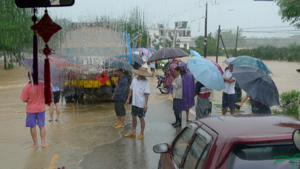

In [173]:
# testing the mapping of Val Set

test_img = modified_val_set[600]['images_val']
test_img.thumbnail((300,300))
test_img

### -------------------------------End of Processing----------------------------------------------------------------------------

In [174]:
from transformers import ViltProcessor, ViltForQuestionAnswering

In [175]:
from transformers import ViltConfig
config = ViltConfig.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

In [176]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [177]:
processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")
model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-mlm", id2label = reverse_mapping, label2id = mapping).to(device)

Some weights of ViltForQuestionAnswering were not initialized from the model checkpoint at dandelin/vilt-b32-mlm and are newly initialized: ['classifier.1.bias', 'classifier.3.bias', 'classifier.0.bias', 'classifier.0.weight', 'classifier.3.weight', 'classifier.1.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [178]:
from torch.utils.data import DataLoader
from datasets import Dataset
import numpy as np

In [179]:
class cric_dataset(Dataset):
    
    def __init__(self, dataset, processor):
        self.processor = processor
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self,idx):
        
        #print(idx)
        item = self.dataset[idx]

        #print(item)
        
        encodings = self.processor(images = item["images"], text = item["questions"], padding="max_length", truncation=True, return_tensors = "pt")
        encodings = {k:v.squeeze() for k,v in encodings.items()}

        labels = item['answers']
        scores = item['scores']
        
        #print(labels)
        #print(scores)
        
        targetWrapper = []
        
        for label, score in zip(labels, scores):
            
            #print(label)
            #print(score)
            
            targets = [0]*len(mapping)
            targets = np.asarray(targets, dtype = float)
            targets[label] = score
            targets = list(targets)
            
            # check targets
            '''
            for i in range(len(targets)):
                if targets[i] == 0.33333333333:
                    print('got 0.3')
                if targets[i] == 1.0: 
                    print('got 1.0')
            '''
            targetWrapper.append(targets)
            
            #print(f'Wrapper Now: {targetWrapper}')
        
        # print(targetWrapper)
        
        encodings["labels"] = torch.tensor(targetWrapper)
        
        return encodings

In [180]:
train_dataset_object = cric_dataset(modified_train_set, processor)

In [181]:
val_dataset_object = cric_dataset(modified_train_set, processor)

In [182]:
def collate_fn(batch):
  
    input_ids = [item['input_ids'] for item in batch]
    pixel_values = [item['pixel_values'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    token_type_ids = [item['token_type_ids'] for item in batch]
    labels = [item['labels'] for item in batch]
        
    # create padded pixel values and corresponding pixel mask
    
    encoding = processor.image_processor.pad(pixel_values, return_tensors="pt")

    # create new batch
    
    batch = {}
    
    batch['input_ids'] = torch.stack(input_ids)
    batch['attention_mask'] = torch.stack(attention_mask)
    batch['token_type_ids'] = torch.stack(token_type_ids)
    batch['pixel_values'] = encoding['pixel_values']
    batch['pixel_mask'] = encoding['pixel_mask']
    batch['labels'] = torch.stack(labels, dim = 0 )

    return batch


In [ ]:
train_dataloader = DataLoader(train_dataset_object, collate_fn = collate_fn, shuffle = True, batch_size = 16)

In [ ]:
batch = next(iter(train_dataloader))

for k,v in batch.items():
    print(k, v.shape)
    print()
    
print(len(train_dataloader))

print(batch.keys())

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=10e-4)

model.train()

for epoch in tqdm(range(5)):  # loop over the dataset multiple times

    print(f"Epoch: {epoch}")

    for batch in train_dataloader:
        # get the inputs;
        batch = {k:v.to(device) for k,v in batch.items()}

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(**batch)
        
        loss = outputs.loss
        
        print("Loss:", loss.item())
        
        loss.backward()
        optimizer.step()

In [184]:
index = 200

In [185]:
example = val_dataset_object[index]
print(example.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'pixel_mask', 'labels'])
